# Evaluation: Fine-Tuned vs Whisper-Base

In [1]:
import torch
import numpy as np
from datasets import load_dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from peft import PeftModel
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm

In [2]:
# Load WER metric
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [3]:
def evaluate_model(model, processor, dataset, device="cuda"):
    """Evaluate a model on a dataset and return metrics"""
    model.to(device)
    model.eval()
    
    all_references = []
    all_predictions = []
    all_audio_names = []
    inference_times = []
    
    for sample in tqdm(dataset, desc="Evaluating"):
        # Get audio input
        audio = sample["path"]
        reference = sample["text"]
        
        # Get audio file name for analysis
        if isinstance(audio, dict) and "path" in audio:
            audio_name = os.path.basename(audio["path"])
        else:
            audio_name = "unknown"
        
        # Process audio
        input_features = processor(
            audio["array"], 
            sampling_rate=audio["sampling_rate"],
            return_tensors="pt"
        ).input_features.to(device)
        
        # Measure inference time
        start_time = time.time()
        with torch.no_grad():
            generated_ids = model.generate(
                input_features=input_features,
                max_new_tokens=128,
                num_beams=1  # Use greedy decoding for faster inference
            )
        end_time = time.time()
        inference_time = end_time - start_time
        
        # Decode prediction
        predicted_transcript = processor.batch_decode(
            generated_ids, skip_special_tokens=True
        )[0]
        
        # Store results
        all_references.append(reference)
        all_predictions.append(predicted_transcript)
        all_audio_names.append(audio_name)
        inference_times.append(inference_time)
    
    # Calculate metrics
    wer = 100 * wer_metric.compute(predictions=all_predictions, references=all_references)
    cer = 100 * cer_metric.compute(predictions=all_predictions, references=all_references)
    
    avg_inference_time = sum(inference_times) / len(inference_times)
    
    # Create detailed results for error analysis
    detailed_results = []
    for ref, pred, name, inf_time in zip(all_references, all_predictions, all_audio_names, inference_times):
        sample_wer = 100 * wer_metric.compute(predictions=[pred], references=[ref])
        detailed_results.append({
            "audio_file": name,
            "reference": ref,
            "prediction": pred,
            "wer": sample_wer,
            "inference_time": inf_time
        })
    
    results = {
        "wer": wer,
        "cer": cer,
        "avg_inference_time": avg_inference_time,
        "detailed_results": detailed_results
    }
    
    return results

In [5]:
# Load the test dataset
data_dir = os.path.abspath(os.path.join("..", "data", "processed"))
test_dataset = load_dataset("csv", data_files=os.path.join(data_dir, "test_data.csv"))["train"]

In [6]:
# Function to correct the file paths
def correct_path(example):
    current_path = example["path"].replace("\\", "/")
    if "../processed" in current_path:
        new_path = current_path.replace("../processed", "../data/processed")
    else:
        new_path = current_path
    example["path"] = new_path
    return example

# Apply the path correction
test_dataset = test_dataset.map(correct_path)

# Cast to Audio
test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [7]:
# Load models and processors
base_model_name = "openai/whisper-base"
base_processor = WhisperProcessor.from_pretrained(base_model_name, language="English", task="transcribe")
base_model = WhisperForConditionalGeneration.from_pretrained(base_model_name)

In [9]:
# Load fine-tuned model
finetuned_model_dir = "../output/models/whisper/best_model"  
finetuned_processor = WhisperProcessor.from_pretrained(base_model_name, language="English", task="transcribe")

# If you're using PEFT/LoRA
finetuned_model = WhisperForConditionalGeneration.from_pretrained(base_model_name)
finetuned_model = PeftModel.from_pretrained(finetuned_model, finetuned_model_dir)

# Use merge_and_unload to get a single model (optional but can improve inference speed)
finetuned_model = finetuned_model.merge_and_unload()

In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Evaluate both models
print("Evaluating base model...")
base_results = evaluate_model(base_model, base_processor, test_dataset, device)

print("Evaluating fine-tuned model...")
finetuned_results = evaluate_model(finetuned_model, finetuned_processor, test_dataset, device)

Evaluating base model...


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Evaluating fine-tuned model...


Evaluating: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


In [12]:
# Print overall results
print("\n===== EVALUATION RESULTS =====")
print(f"Base Whisper WER: {base_results['wer']:.2f}%")
print(f"Fine-tuned Whisper WER: {finetuned_results['wer']:.2f}%")
print(f"WER improvement: {base_results['wer'] - finetuned_results['wer']:.2f}%")

print(f"\nBase Whisper CER: {base_results['cer']:.2f}%")
print(f"Fine-tuned Whisper CER: {finetuned_results['cer']:.2f}%")
print(f"CER improvement: {base_results['cer'] - finetuned_results['cer']:.2f}%")

print(f"\nBase model avg inference time: {base_results['avg_inference_time']:.4f}s")
print(f"Fine-tuned model avg inference time: {finetuned_results['avg_inference_time']:.4f}s")


===== EVALUATION RESULTS =====
Base Whisper WER: 122.81%
Fine-tuned Whisper WER: 21.05%
WER improvement: 101.75%

Base Whisper CER: 123.61%
Fine-tuned Whisper CER: 6.94%
CER improvement: 116.67%

Base model avg inference time: 0.4230s
Fine-tuned model avg inference time: 0.1755s


In [13]:
# Create comparison of individual file performance
base_wers = [item["wer"] for item in base_results["detailed_results"]]
finetuned_wers = [item["wer"] for item in finetuned_results["detailed_results"]]
audio_files = [item["audio_file"] for item in base_results["detailed_results"]]

In [14]:
# Create and save a comparison table
comparison_df = pd.DataFrame({
    "Audio File": audio_files,
    "Base WER": base_wers,
    "Fine-tuned WER": finetuned_wers,
    "WER Improvement": [b - f for b, f in zip(base_wers, finetuned_wers)],
    "Base Reference": [item["reference"] for item in base_results["detailed_results"]],
    "Base Prediction": [item["prediction"] for item in base_results["detailed_results"]],
    "Fine-tuned Prediction": [item["prediction"] for item in finetuned_results["detailed_results"]]
})

In [16]:
# Save to CSV
os.makedirs("../output/evaluations", exist_ok=True)
comparison_df.to_csv("../output/evaluations/whisper_comparison.csv", index=False)
print(f"Detailed comparison saved to ../output/evaluations/whisper_comparison.csv")

Detailed comparison saved to ../output/evaluations/whisper_comparison.csv


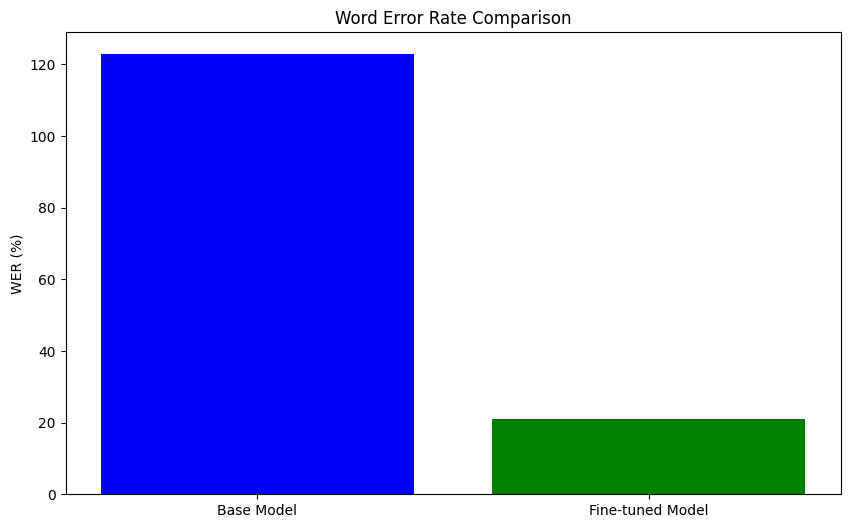

In [18]:
# Create visualizations
plt.figure(figsize=(10, 6))
plt.bar(['Base Model', 'Fine-tuned Model'], [base_results['wer'], finetuned_results['wer']], color=['blue', 'green'])
plt.title('Word Error Rate Comparison')
plt.ylabel('WER (%)')
plt.savefig("../output/evaluations/wer_comparison.png")

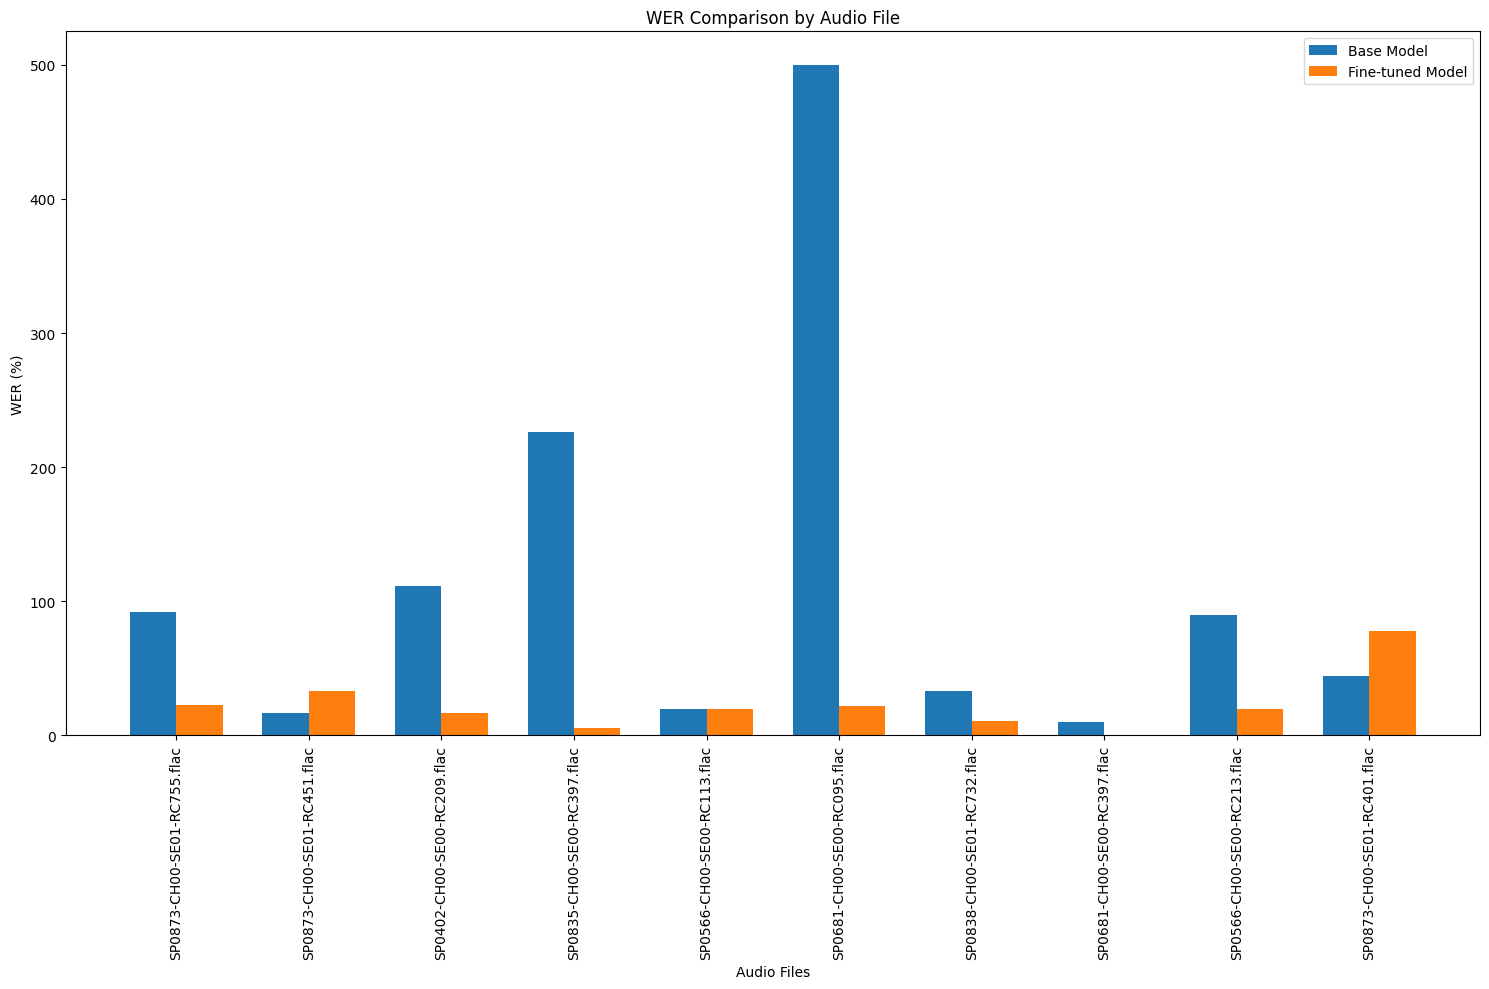

In [19]:
# Compare individual audio file performance
plt.figure(figsize=(15, 10))
indices = range(len(audio_files))
width = 0.35
plt.bar(indices, base_wers, width, label='Base Model')
plt.bar([i + width for i in indices], finetuned_wers, width, label='Fine-tuned Model')
plt.xlabel('Audio Files')
plt.ylabel('WER (%)')
plt.title('WER Comparison by Audio File')
plt.xticks([i + width/2 for i in indices], audio_files, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("../output/evaluations/wer_by_file.png")

In [20]:
# Error analysis for failed cases
# Find examples where fine-tuned model performed worse
worse_cases = comparison_df[comparison_df["WER Improvement"] < 0].sort_values("WER Improvement")

if len(worse_cases) > 0:
    print("\n===== CASES WHERE FINE-TUNED MODEL PERFORMED WORSE =====")
    for _, row in worse_cases.head(5).iterrows():
        print(f"\nAudio: {row['Audio File']}")
        print(f"Reference: {row['Base Reference']}")
        print(f"Base model: {row['Base Prediction']} (WER: {row['Base WER']:.2f}%)")
        print(f"Fine-tuned: {row['Fine-tuned Prediction']} (WER: {row['Fine-tuned WER']:.2f}%)")
        print(f"WER change: {row['WER Improvement']:.2f}%")


===== CASES WHERE FINE-TUNED MODEL PERFORMED WORSE =====

Audio: SP0873-CH00-SE01-RC401.flac
Reference: a smile can often lift up a weary spirit.
Base model:  A small can of them lift up a weary spirit. (WER: 44.44%)
Fine-tuned: a small can of them lived up at a weird spirit (WER: 77.78%)
WER change: -33.33%

Audio: SP0873-CH00-SE01-RC451.flac
Reference: the shop keeps its costs low by buying its supplies in bulk.
Base model:  The shop keeps its cost low by buying its supplies in bulk. (WER: 16.67%)
Fine-tuned: the shop keeps its cause low buy buying it supplies in bulk (WER: 33.33%)
WER change: -16.67%


In [21]:
# Find examples where fine-tuned model performed much better
better_cases = comparison_df[comparison_df["WER Improvement"] > 0].sort_values("WER Improvement", ascending=False)

if len(better_cases) > 0:
    print("\n===== CASES WHERE FINE-TUNED MODEL PERFORMED BETTER =====")
    for _, row in better_cases.head(5).iterrows():
        print(f"\nAudio: {row['Audio File']}")
        print(f"Reference: {row['Base Reference']}")
        print(f"Base model: {row['Base Prediction']} (WER: {row['Base WER']:.2f}%)")
        print(f"Fine-tuned: {row['Fine-tuned Prediction']} (WER: {row['Fine-tuned WER']:.2f}%)")
        print(f"WER change: {row['WER Improvement']:.2f}%")


===== CASES WHERE FINE-TUNED MODEL PERFORMED BETTER =====

Audio: SP0681-CH00-SE00-RC095.flac
Reference: most youths today think that their future is uncertain.
Base model:  Mestk menggunakan hari ini fikir kata-kata mereka akan menggunakan sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah sebuah (WER: 500.00%)
Fine-tuned: most used today think that their future is uncertain (WER: 22.22%)
WER change: 477.78%

Audio: SP0835-CH00-SE00-RC397.flac
Reference: many countries require a passport to be valid for at least six months as part of their entry requirements.
Base model:  Mereka perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan perlukan pe